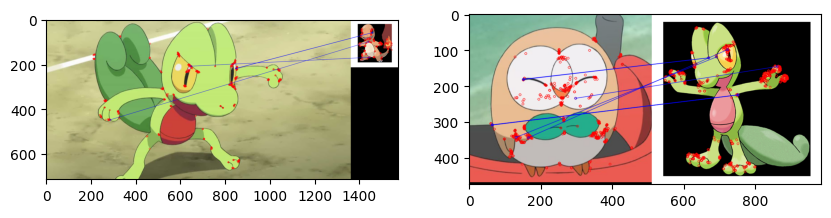

In [ ]:
# type: ignore
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

path = './Images/Data/'
object1_path = './Images/Object.png'
object2_path = './Images/Object2.png'

def load_preprocess(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), img_gray

# var 1 (sesuai soal)
target1, target1_gray = load_preprocess(object1_path)
target1_gray = cv2.medianBlur(target1_gray, 5) # sesuai soal

# var 2 (sesuai soal)
target2, target2_gray = load_preprocess(object2_path)
target2_gray = cv2.GaussianBlur(target2_gray, (3, 3), 0) # sesuai soal

akaze = cv2.AKAZE.create()
sift = cv2.SIFT.create()
orb = cv2.ORB.create()

obj1_kp , obj1_desc = sift.detectAndCompute(target1_gray, None) # orb/sift.detectAndCompute(target1_gray, None)
obj2_kp , obj2_desc = sift.detectAndCompute(target2_gray, None)

def feature_matching(desc, target_desc):

    flann = cv2.FlannBasedMatcher(dict(algorithm = 1), dict(checks = 50))
    match = flann.knnMatch(np.float32(target_desc), desc, k = 2)
    
    match_mask = [[0, 0] for _ in range(len(match))]
    
    curr = 0
    for i, (fm, sm) in enumerate(match):
        # lowe ratio test
         if fm.distance < 0.7 * sm.distance:
            curr += 1
            match_mask[i] = [1, 0]
            
    return match, match_mask, curr

best1 = 0
best2 = 0

for file in os.listdir(path):
    img, img_gray = load_preprocess(path + file)
    
    img1_gray = cv2.medianBlur(img_gray, 5)
    img2_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)
    
    img1_kp , img1_desc = sift.detectAndCompute(img1_gray, None) # orb/sift.detectAndCompute(img1_gray, None)
    img2_kp , img2_desc = sift.detectAndCompute(img2_gray, None)
    
    img1_desc = np.float32(img1_desc)
    img2_desc = np.float32(img2_desc)
    
    match1, match1_mask, curr_match1 = feature_matching(img1_desc, obj1_desc)
    match2, match2_mask, curr_match2 = feature_matching(img2_desc, obj2_desc)
    
    if curr_match1 > best1:
        best1 = curr_match1
        best_data1 = {
            'img': img,
            'keypoint': img1_kp,
            'matches': match1,
            'mask': match1_mask
        }
        
    if curr_match2 > best2:
        best2 = curr_match2
        best_data2 = {
            'img': img,
            'keypoint': img2_kp,
            'matches': match2,
            'mask': match2_mask
        }
        
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
result = cv2.drawMatchesKnn(target1, obj1_kp, 
                            best_data1['img'], 
                            best_data1['keypoint'], 
                            best_data1['matches'], 
                            None, 
                            matchColor=[0, 0, 255], 
                            singlePointColor= [255, 0, 0],
                            matchesMask= best_data1['mask']
                            )
plt.imshow(result)

plt.subplot(1, 2, 2)
result = cv2.drawMatchesKnn(target2, obj2_kp, 
                            best_data2['img'], 
                            best_data2['keypoint'], 
                            best_data2['matches'], 
                            None, 
                            matchColor=[0, 0, 255], 
                            singlePointColor= [255, 0, 0],
                            matchesMask= best_data2['mask']
                            )
plt.imshow(result)
plt.show()